# Implemant HUMAN ACTIVITY RECOGNITION via LSTM with different Architecture

In [1]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

C:\Users\HIMANSHU NEGI\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [13]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [14]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [49]:
# Initializing parameters
epochs = 20
batch_size = 16
n_hidden2 = 18
n_hidden1 = 36

In [50]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [51]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\HIMANSHU NEGI\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [52]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

# (1) Model having 1 LSTM layer with 32 LSTM Units

In [29]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 32)                5376      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [31]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 74s 10ms/step - loss: 1.3657 - acc: 0.4223 - val_loss: 1.2432 - val_acc: 0.4476
Epoch 2/20
7352/7352 [==============================] - 72s 10ms/step - loss: 1.1265 - acc: 0.4933 - val_loss: 1.0647 - val_acc: 0.4472
Epoch 3/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.9105 - acc: 0.5741 - val_loss: 0.9171 - val_acc: 0.5843
Epoch 4/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.7974 - acc: 0.6465 - val_loss: 0.8289 - val_acc: 0.6016
Epoch 5/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.6969 - acc: 0.6568 - val_loss: 0.7589 - val_acc: 0.6098
Epoch 6/20
7352/7352 [==============================] - 70s 10ms/step - loss: 0.6716 - acc: 0.6560 - val_loss: 0.8594 - val_acc: 0.6047
Epoch 7/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.7123 - acc: 0.6536 - val_loss: 0.7254 - val_acc: 0.6166
Epoc

In [32]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0         0        0                   0   
SITTING                  1      385       102        2                   0   
STANDING                 0      101       429        2                   0   
WALKING                  0        1         3      485                   4   
WALKING_DOWNSTAIRS       0        0         0       27                 389   
WALKING_UPSTAIRS         1        0         1       56                  22   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            25  
SITTING                            1  
STANDING                           0  
WALKING                            3  
WALKING_DOWNSTAIRS                 4  
WALKING_UPSTAIRS                 391  


In [33]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 621us/step


In [34]:
score

[0.4219474009271998, 0.8791991856124872]

# (2) Model having 1 LSTM layer with 64 LSTM Units and 'rmsprop' as an optimizer

In [35]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [37]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 54s 7ms/step - loss: 1.2354 - acc: 0.4479 - val_loss: 1.2075 - val_acc: 0.3868
Epoch 2/20
7352/7352 [==============================] - 53s 7ms/step - loss: 1.0049 - acc: 0.5355 - val_loss: 0.9058 - val_acc: 0.5826
Epoch 3/20
7352/7352 [==============================] - 53s 7ms/step - loss: 0.7873 - acc: 0.6240 - val_loss: 0.7922 - val_acc: 0.6047
Epoch 4/20
7352/7352 [==============================] - 54s 7ms/step - loss: 0.7871 - acc: 0.6310 - val_loss: 0.7214 - val_acc: 0.6115
Epoch 5/20
7352/7352 [==============================] - 54s 7ms/step - loss: 0.6317 - acc: 0.6597 - val_loss: 0.7588 - val_acc: 0.6206
Epoch 6/20
7352/7352 [==============================] - 54s 7ms/step - loss: 0.5755 - acc: 0.6814 - val_loss: 0.7319 - val_acc: 0.6237
Epoch 7/20
7352/7352 [==============================] - 54s 7ms/step - loss: 0.5225 - acc: 0.7531 - val_loss: 0.6146 - val_acc: 0.7988
Epoch 8

In [38]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      383       105        0                   1   
STANDING                 0      108       424        0                   0   
WALKING                  0        0         0      440                  54   
WALKING_DOWNSTAIRS       0        0         0        3                 417   
WALKING_UPSTAIRS         0        0         0        4                  22   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                            2  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 445  


In [39]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 903us/step


In [40]:
score

[0.5296491873798939, 0.8887003732609433]

# (3) Model having 2 LSTM layer with 32 LSTM Units and 'rmsprop' as an optimizer

In [59]:

# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model4.add(Dropout(0.5))

# Configuring the parameters
model4.add(LSTM(32))
# Adding a dropout layer
model4.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history4 = model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 116s 16ms/step - loss: 1.2293

Test Score: 0.474115
Test Accuracy: 90.804208%


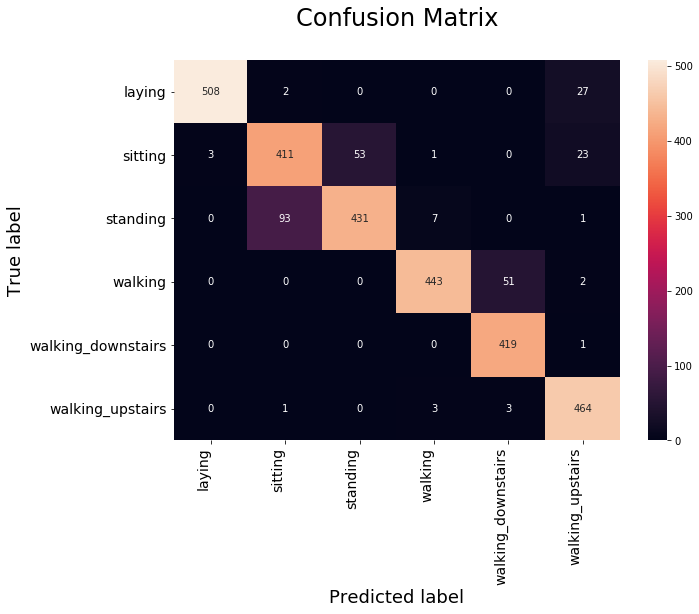

In [61]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
scores4 = model4.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores4[0]))
print("Test Accuracy: %f%%" % (scores4[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model4.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (4) Model having 2 LSTM layer with 32 LSTM Units and 'rmsprop' as an optimizer

In [72]:

# Initiliazing the sequential model
model7 = Sequential()
# Configuring the parameters
model7.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model7.add(Dropout(0.4))

# Configuring the parameters
model7.add(LSTM(32))
# Adding a dropout layer
model7.add(Dropout(0.4))
# Adding a dense output layer with sigmoid activation
model7.add(Dense(n_classes, activation='sigmoid'))
print(model7.summary())

# Compiling the model
model7.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history7 = model7.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=30)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_20 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 112s 15ms/step - loss: 1.1430

Test Score: 0.390201
Test Accuracy: 90.532745%


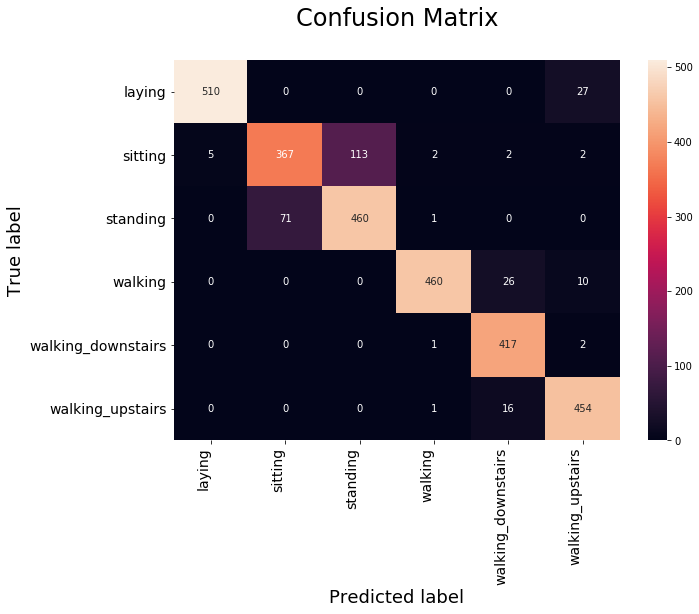

In [74]:

scores7 = model7.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores7[0]))
print("Test Accuracy: %f%%" % (scores7[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model7.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (5) Model having 2 LSTM layer with 64 LSTM Units

In [75]:

# Initiliazing the sequential model
model8 = Sequential()
# Configuring the parameters
model8.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model8.add(Dropout(0.3))

# Configuring the parameters
model8.add(LSTM(64))
# Adding a dropout layer
model8.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model8.add(Dense(n_classes, activation='sigmoid'))
print(model8.summary())

# Compiling the model
model8.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history8 = model8.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=30)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 126s 17ms/step - loss: 1.0656

Test Score: 0.448009
Test Accuracy: 90.939939%


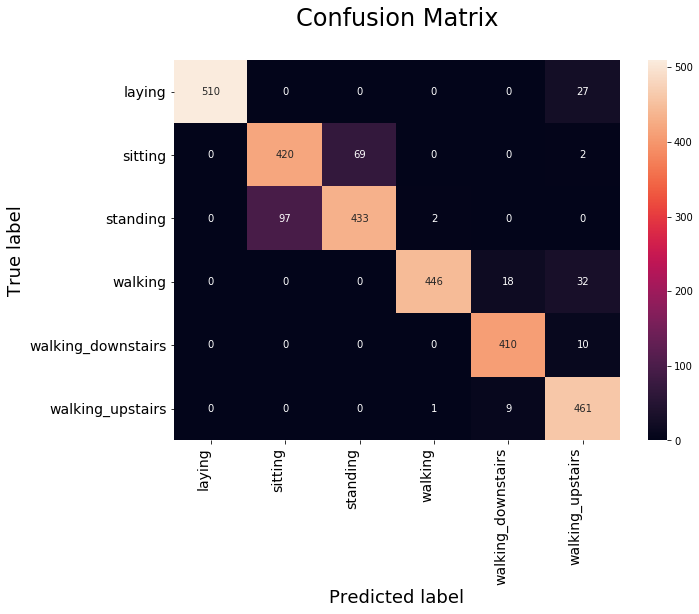

In [76]:

scores8 = model8.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores8[0]))
print("Test Accuracy: %f%%" % (scores8[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model8.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (6) Model having 2 LSTM layer with 64 LSTM Units

In [77]:

# Initiliazing the sequential model
model9 = Sequential()
# Configuring the parameters
model9.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model9.add(Dropout(0.5))

# Configuring the parameters
model9.add(LSTM(64))
# Adding a dropout layer
model9.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model9.add(Dense(n_classes, activation='sigmoid'))
print(model9.summary())

# Compiling the model
model9.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history9 = model9.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=30)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 142s 19ms/step - loss: 1.0596

Test Score: 0.523963
Test Accuracy: 90.498812%


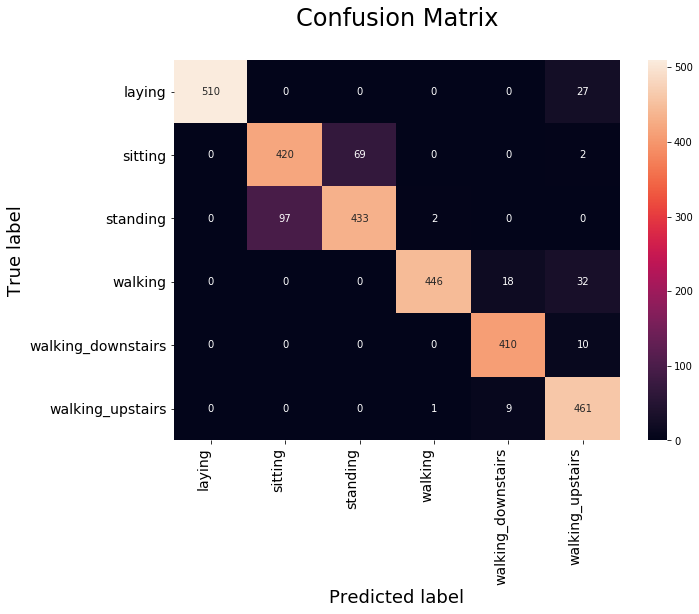

In [78]:

scores9 = model9.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores9[0]))
print("Test Accuracy: %f%%" % (scores9[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model8.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION

# (a). Procedure Followed :

STEP 1 :- Load the data and split into training_data and test_data

STEP 2:-Try out different LSTM architectures

STEP 3:- Find test score and accuracy for each model

STEP 4:- Draw confusion matrix using seaborn heatmap for each model

# (b). Table (Model performances) :

In [83]:


from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Epocs","DROPOUT","Training_Accuracy% ", "Test_Accuracy% "]

x.add_row(["1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)",20,.5,93.27,87.91])

x.add_row(["1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)",20,.5,94.63,88.87])

x.add_row(["2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)",20,.5,94.97,90.80])

x.add_row(["2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)",30,.4,95.43,90.53])

x.add_row(["2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)",30,.3,95.23,90.93])

x.add_row(["2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)",30,.5,95.16,90.49])

print(x)

+------------------------------------------------------+-------+---------+---------------------+-----------------+
|                        Model                         | Epocs | DROPOUT | Training_Accuracy%  | Test_Accuracy%  |
+------------------------------------------------------+-------+---------+---------------------+-----------------+
| 1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) |   20  |   0.5   |        93.27        |      87.91      |
| 1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) |   20  |   0.5   |        94.63        |      88.87      |
| 2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) |   20  |   0.5   |        94.97        |       90.8      |
| 2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) |   30  |   0.4   |        95.43        |      90.53      |
| 2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) |   30  |   0.3   |        95.23        |      90.93      |
| 2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) |   30  |   0.5   |      